draft notes:

RBFN:

- input:
    - fft of the signal ( frequency - amplitude representation (1d array) )
    OR
    - time series (1d array) of the spectogram of the signal

- output:
    - no output layer ?
    - normalize
    
    - compressed representation of the signal, construct a frequency - amplitude representation out of the centers and the output as weights of the RBFN
    OR
    - either reconstruct the time series of the spectogram with the centers and their output as weights
    OR
    - use the compressed representation as the input to generate spikes of num_centers input neurons

- hidden layer:
    - radial basis functions 
        - gaussian
        - other RBF

- training:
    - for now no training
    - centers from unsupervised clustering (kmeans?)
    

possible implementation:
https://github.com/rssalessio/PytorchRBFLayer/tree/main

In [14]:
import torch
import torch.nn as nn

class RBF(nn.Module):
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}|| / s_{i})

    Arguments:
        in_features: size of each input sample
        out_features: size of each output sample

    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, out_features) where N is an arbitrary batch size

    Attributes:
        centres: the learnable centres of shape (out_features, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.
        
        log_sigmas: logarithm of the learnable scaling factors of shape (out_features).
        
        basis_func: the radial basis function used to transform the scaled
            distances.
    """
    def __init__(self, in_features, out_features, basis_func):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centres = nn.Parameter(torch.Tensor(out_features, in_features))
        self.log_sigmas = nn.Parameter(torch.Tensor(out_features))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.centres, 0, 1)
        nn.init.constant_(self.log_sigmas, 0)

    def forward(self, input):
        size = (input.size(0), self.out_features, self.in_features)
        x = input.unsqueeze(1).expand(size)
        c = self.centres.unsqueeze(0).expand(size)
        distances = (x - c).pow(2).sum(-1).pow(0.5) / torch.exp(self.log_sigmas).unsqueeze(0)
        return self.basis_func(distances)

class RBFNet(nn.Module):
    def __init__(self, in_features, out_features, basis_func):
        super(RBFNet, self).__init__()
        self.rbf = RBF(in_features, out_features, basis_func)
        # self.linear = nn.Linear(out_features, 1)

    def forward(self, x):
        out = self.rbf(x)
        # out = self.linear(out)
        return out
    
    def __call__(self, x):
        return self.forward(x)
    def fit():
        pass


In [15]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.fftpack
from scipy.ndimage import convolve1d
from scipy.signal.windows import exponential, gaussian
from scipy.signal import square, ShortTimeFFT

import IPython.display as ipd

In [16]:
from datasets import load_dataset
data = load_dataset('google/speech_commands', 'v0.01', split='train', trust_remote_code=True)

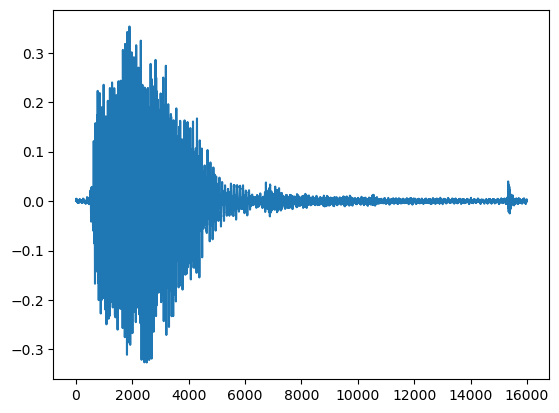

In [17]:
path, samp, samp_rate = data['audio'][0].values()
plt.plot(samp)
plt.show()
ipd.Audio(samp, rate=samp_rate)

In [18]:
import numpy as np
from scipy.signal import stft
import librosa

def mel_spectrogram(audio, sample_rate, n_mels=128, f_min=0, f_max=None):
  if f_max is None:
    f_max = sample_rate / 2
#   _, _, spectrogram = stft(audio, nperseg=1024, noverlap=512, fs=sample_rate)
#   print("spectrogram: ", spectrogram.shape)
#   mel_spectrogram = librosa.feature.melspectrogram(spectrogram, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max)
  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, fmin=f_min, fmax=f_max)

  return mel_spectrogram

def rbf_encode_audio(audio, sample_rate, n_mels=128, num_rbf=256, sigma=1.0):
  mel_spec = mel_spectrogram(audio, sample_rate, n_mels)
#   mel_spec = np.abs(mel_spec)
  print("shape mel_spec: ", mel_spec.shape)
  rbf_network = RBFNet(mel_spec.shape[0], num_rbf, gaussian)
  rbf_activations = rbf_network(mel_spec.T)  # transpose to get the batch dimension first
  return rbf_activations, mel_spec

In [19]:
rbf_acts, mel_spec = rbf_encode_audio(samp, samp_rate, n_mels=128, num_rbf=256, sigma=1.0)
print("rbf_acts: ", rbf_acts.shape)

shape mel_spec:  (128, 32)


TypeError: 'int' object is not callable

In [3]:
def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi